#Project Description 
All aspects of this project are run locally on my own personal machine through a local runtime connection with Google Colab and Juypter-notebook. The code presented here is not usable by everyone because the paths and imports may be different depending on disk setup and machine. \

Author: Arpanpal Singh \
Kaggle User: Arpanpal Singh \
UW NetId: Arpans@uw.edu

## Project Goals 
This project is in line with CSE 455 spring 2022 kaggle competition. The premise is to use advanced computer vision and machine learning on the provided kaggle birds dataset to accurately classify bird specifies. The training set consists of 10,000 pictures with varying dimensions. The test set consists of 1,000 pictures with varying dimensions. There are a total of 555 different possible specifies for each picture. 

## Underlying PC Specifications
AMD Ryzen 7 5800X 8-Core Processor 3.80 GHz \
EVGA FTW3 NVIDIA Geforce RTX 3080 w/ 8704 CUDA Cores \
Corsair Vengeance DDR4 32gb RAM


## Code summary

Large portions of the code are from the tutorial code, as they worked perfectly fine for me as they were. Specifcally, the train and predict functions are nearly identical. The vast majority of the workload was researching, training, and testing the many different models I used. I use pytorch and torchvision for almost everything important in the project. All models are from the torchvision library.

All the code for setting up the environment locally is written by me. I did not use code from any pre-existing githubs. Only from tutorials provided by the professor, and my own implementations when necessary.

#1) Intialization 

The following are all the intialization steps necessary to run the project locally. They are heavily influenced and pieced together from the tutorial, however modified so as to work on my personal setup. The paths and things alike would/can be very different depending on whose running the project.

### 1.1) Directory Creation 

Since we are working locally, it is important to create or navigate to the correct directories before we start running Python code. \

First we import the OS module of Python, which allows us to work with the underlying OS system. We create the birds22sp directory, if it doesn't exist already, and download the datasets necessary for the training and testing. We also create the checkpoints directory which is necessary for remembering training for our different networks. \

Working locally means that I do not have to download the dataset multiple times. Once it's on my machine, I can train and run on it whenever I want. The checkpoints directory, which in the original code was in my Google drive, is now a part of the birds22sp directory and the path slightly modified.

In [3]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Verify current working directory, and move to Desktop 
print("The current working directory is: " + os.getcwd())
os.chdir("/Users/Arpan/Desktop") #Move to Desktop, which is where the project files will be stored
print("Moved working directory to: " + os.getcwd())

# Verify that birds21wi folder exists
if not os.path.exists("birds22sp"):
    !mkdir birds22sp
    os.chdir("birds22sp")
    !python3 -m wget https://pjreddie.com/media/files/birds/train.tar
    !python3 -m wget https://pjreddie.com/media/files/birds/test.tar
    !python3 -m wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !move test testing
    print("birds22sp has been installed to:" + os.getcwd())
    print("Moved working directory to: " + os.getcwd())
else:
  os.chdir("birds22sp")
  print("birds22sp was already installed at: " + os.getcwd())
  print("Moved working directory to: " + os.getcwd())

# Create the checkpoints folder 
checkpoints = '/Users/Arpan/Desktop/birds22sp/content/checkpoints/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)
    print("Made checkpoints directory")

The current working directory is: C:\Users\Arpan\Desktop\birds22sp
Moved working directory to: C:\Users\Arpan\Desktop
birds21wi was already installed at: C:\Users\Arpan\Desktop\birds22sp
Moved working directory to: C:\Users\Arpan\Desktop\birds22sp


### 1.2 Imports & GPU intialization 

Now we can start running Python to start building our project. The project HEAVILY uses Pythons torch libraries, so it is important that we import all of them. I also have a powerful GPU in my personal machine, so it's optimal to set the torch device to  use the GPU and cuda cores inside it. \

NOTE: I had to spent 1-2 hours setting up CUDA for my GPU as the process for confusing to me, as well as install Pytorch locally.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Output the device (Should be Cuda:0 if cuda is installed)
print(device)

cuda:0


# 2) Data Initialization 

The data is initialized into tensors so that we can train with it. \

This is one of the most important aspects of the code, as how we choose to agument and intialize the testing and training sets HEAVILY influence the end accuracy of the model, as well as the amount of memory/GPU usage the code needs. \

In the training set, the images are resized to one of a few different pixel dimensions, then randomly cropped, and flipped horizontally. \

In the testing set, the images are simply resized to the same pixel dimension, but kept otherwise the same. \

The different dimensions I tested with:
`(128x128), (256x256), (288x288), (384x384)`

Another very aspect of the code is the batch size in the training set. The batch size essentially determins how many pictures the code is able to train on at 1 time. The higher the batch size, the most memory it takes, but the faster the network runs. I useed the following batch sizes depending on the memory load: `32, 64, 128`.

In [5]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(384),
        transforms.RandomCrop(384, padding=8, padding_mode='edge'), # Take crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(384),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

# 3) Training Defintion  

The following code is used to train. The `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For this network I'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood). This loss function is optimal for multi-class classifications like the birds data.

For the optimizer I am using stochastic gradient descent with learning rate, momentum, and decay parameters.

Note: Code is relatively unchanged from tutorial, as it accomplished everything I needed. Minor change to the cehckpoint paths and output names.

In [6]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'resNet50Size384/checkpoint-%d.pkl'%(epoch+1))
  return losses

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

# 4) Neural Networks Definitions

The real core of the project was to utilize different classification models and ascertain which ones were the most opitmal and give the best results. Every single model is from the Pytorch library, which contains a fairly large set of pretrained models. A major goal of the project was to hit a relatively high accuracy, which meant that I had to find the best models, but they all also had to be able to RUN on my machine.



## 4.1) ResNet18
This is the first model I attempted as it was used in the tutorial code. ResNet18 is a 72 layer architecture with 18 deep layers.  

In [7]:
resnet18 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet18.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

Using cache found in C:\Users\Arpan/.cache\torch\hub\pytorch_vision_v0.6.0


The model performed competitively from the get go, and was not extremely memory intensive. 

The first iteration was ran on `128x128` inputs with a batch size of 128. It was ran for 10 epochs at a constant learning rate of 0.01. The resulting accuracy when submitted on kaggle was: **64.850%**

The second iteration was ran on the same inputs and batch size, but for 10 epochs, with a schedule of = {0: 0.01, 10: 0.005}. The resulting accuracy was: **66.350%**

The next iteration was ran on `256x256` inputs with batch size of 128. It ran for 20 epochs, with the following schedule = {0: 0.01, 10: 0.005, 15: 0.001}. The resulting accuracy was: **78.150%**

This was a massive jump in accuracy, and was one of the most important discoveries I made during my testing. I went and looked at the data set and checked the dimensions of the pictures present and realized that the dimensions were far larger than the inital `128x128` crops I was making following the tutorial. Every single picture I saw was at least 400x400 in dimension, with most of them being significantly larger. Resizing to such a low picture dimension meant that I was loosing TONS of pixel information, resulting in the network performing much lower. Hence from this point forward, I strictly only used inputs equal to or larger than `256x256`, and made sure all of them were multiples of 32.

The last iteration of this network was ran on `384x384` inputs with batch size of 128. ResNet is designed to take images that are multiples of 32. The network ran for 30 epochs, with a schedule of = {0:.01, 5:.005, 10:.001, 20:.0005}. The resuling accuracy was the best so far at: **80.150%**

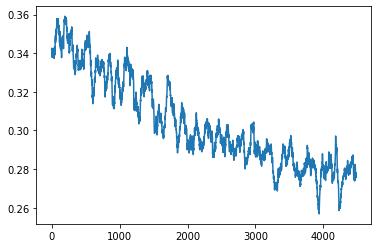

In [8]:
restNet18_state = torch.load(checkpoints + 'resNet18Size384/checkpoint-15.pkl')
plt.plot(smooth(restNet18_state['losses'], 50))

By the end of the 30th epoch, we have hit a loss rate of around 0.28. \
*Note that this only shows the loss from the 15th to the 30th epoch. I lost the data due to overwrite of the first 15 epochs.*

## 4.2) ResNet152

The second model I attempted, which quickly taught me the reason why GPUs and hardware are so important in computer vision and machine learning. Shoutout $10k GPUs, which always baffled me with their prices. As the name suggests, this model has 152 deep layers.

In [ ]:
resnet152 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
resnet152.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well

Using cache found in C:\Users\Arpan/.cache\torch\hub\pytorch_vision_v0.6.0


This model is without a doubt the most powerful model I attempted to run during my testing. It has one of the lowest top 1% and 5% error rates of any of the models present in torch vision, which immediately attracted me to it. However, I quickly disovered that it's not feasble for me to use with my setup.

The first iteration of the model used `128x128` inputs with 128 batch size and ran for 10 epochs with a constant learning rate of 0.01. The resulting accuracy was WORSE than resNet18 at: **63.100%** which initially really confused me. It made no sense why a resNet152, which is objectively a better version of resNet18 would perform worse. However, its important to understand that for models like this which go extremely deep in the layers, the input image needs to be much larger. With 152 deep layers, an input image of `128x128` just won't cut it. 

So I attempted to raise the input to `256x256` and `384x384`. Unfortunately, both are not possible, as the amount of memory with those inputs, and the 128 batch size are far too much for the 10gb VRAM in my card. Hence I tried to lower the batch size. The only combination I tested which actually ran without crashing due to CUDA out of memory errors was `256x256` with a batch size of 16. Unfortuntely, with such a small batch size, the run time of the code on my set up would be nearly 30 hours before it finished. It was at this point that I dropped resNet152 as a possible network for this project. 

NOTE: I am confident that had I access to a larger machine with more resources, this network would without a doubt result in the highest accuracy.

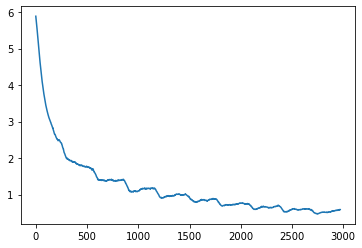

In [9]:
restNet152_state = torch.load(checkpoints + 'resNet152/checkpoint-10.pkl')
plt.plot(smooth(restNet152_state['losses'], 50))

By the end of the 10th epoch, we have hit a loss of rougly 0.9.

## 4.3) DenseNet

The third network I attempted to use was densenet161, which is nearly as powerful and competitive with resNet152. However, just like resNet152, I very quickly learned that it was not possible for me to run this network on my set up. If I wanted to run it, the input image size would be too small to get a good accuracy. I never got a full iteration finished with this network because I already understood the end result would be similar to resNet152

In [ ]:
densenet161 = torch.hub.load('pytorch/vision:v0.6.0', 'densenet161', pretrained=True)
densenet161.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well

Using cache found in C:\Users\Arpan/.cache\torch\hub\pytorch_vision_v0.6.0


## 4.4) ResNet50
The fourth network I attempted to use, and by FAR the best of all worlds for my machine. ResNet50 is a power 50 deep layer network, which is not only relatively affordable in terms of memory usable, but very powerful in classifcation.

In [4]:
resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
resnet50.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well

Using cache found in C:\Users\Arpan/.cache\torch\hub\pytorch_vision_v0.6.0


The first iteration of this network was ran on `288x288` input size images, with a batch of 64. This setup maximized my 10gb VRAM without going over the limit. It ran for 30 epochs, with a schedule of = {0:.01, 5:.005, 10:.001, 20:.0005}. The final accuracy for this iteration was: **85.600%**.

The second iteration of this network was ran on `384x384` input size images, with a batch of 32. This setup once again maximize my memory, but also allowed the network to have bigger images to work with when layering. It also ran for 30 epochs, with a schedule of = {0:.01, 5:.005, 10:.001, 20:.0005}. The final accuracy for t his iteration was: **87.100**.

After this, I attempted to use bigger resNet model (resNet101) but again ran into memory and time constraints. Hence, instead, I took this same model, and for an extra 20 more epochs, finalizing at 50 epochs for the second iteration. The schedule was = {0:.01, 5:.005, 10:.001, 20:.0005, 35: .0001}. The final accuracy barely went up at all, with it end at: **87.150%**. 

This was the highest accuracy I could acquire, and it placed me at 1st place on the kaggle leaderboard at the time of this writing, with a 5% lead on second place.

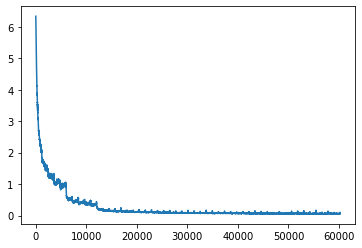

In [10]:
resNet50_state = torch.load(checkpoints + 'resNet50Size384/checkpoint-50.pkl')
plt.plot(smooth(resNet50_state['losses'], 50))

The final loss rate hovered around 0.5-0.6 by the end of the model.

## 4.5 ResNet101

As mentioned above, resNet101 was another model I tried as a means of upping the accuracy from resNet50, since this model has double the deep layers. However, like resNet152 and denseNet161, this model requires far too many resources and time for me to be able to feaseably run.

In [ ]:
resnet101 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True)
resnet101.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well

Using cache found in C:\Users\Arpan/.cache\torch\hub\pytorch_vision_v0.6.0


## 4.6) VGG 19
The final model I attempted was the VGG 19 network. This is yet another powerful network with a top 1% error of 27.62 and top 5% error of 9.125%. It's essentially a middle ground between resNet18 and resNet50 in terms of error percentage, however the memory usage is too high for the improvement in quality. It's just better to use resNet50.

In [ ]:
vgg19 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
vgg19.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

Using cache found in C:\Users\Arpan/.cache\torch\hub\pytorch_vision_v0.6.0


The first and only iteration of this model that I ran was on `256x256` size input images, with batch of 32. This is probably the main reason why the final accuracy fell short of resNet18 as I was forced to use lower resolution images to fit the model in the GPU. The network ran for 30 epochs, with a schedule of = {0:.01, 5:.005, 10:.001, 20:.0005}. The final accuracy was: **73.900%**, which well within my expectations.

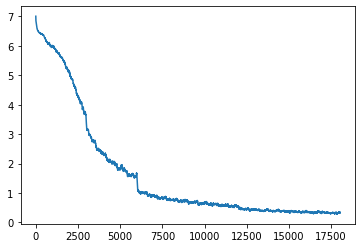

In [11]:
vgg19_state = torch.load(checkpoints + 'vgg19Size256/checkpoint-30.pkl')
plt.plot(smooth(vgg19_state['losses'], 50))

Final loss rate hovered around 0.6

## 4.7) Running Training 

The following were the training commands used to run the train code on each of the models.

Run ResNet18 for 30 epochs



In [ ]:
resNet18_losses = train(resnet18, data['train'], epochs=30, schedule={0:.01, 5:.005, 10:.001, 20:.0005}, lr=.01, print_every=10, checkpoint_path=checkpoints)

Run ResNet50 for 30 epochs

In [ ]:
resNet50_losses = train(resnet50, data['train'], epochs=50, schedule={0:.01, 5:.005, 10:.001, 20:.0005}, lr=.01, print_every=10, checkpoint_path=checkpoints)

Run ResNet50 for 50 epochs by using a pretrained resNet50 which had already trained 30 epochs.

In [ ]:
resNet50_state = torch.load(checkpoints + 'resNet50Size384/checkpoint-30.pkl')
resnet50.load_state_dict(resNet50_state['net'])
resNet50_losses = train(resnet50, data['train'], epochs=50, schedule={0:.01, 5:.005, 10:.001, 20:.0005, 35: .0001}, lr=.01, print_every=10, checkpoint_path=checkpoints, state=resNet50_state)

Run ResNet101 for 30 epochs 

In [ ]:
resnet101_losses = train(resnet101, data['train'], epochs=30, schedule={0:.01, 5:.005, 10:.001, 20:.0005}, lr=.01, print_every=10, checkpoint_path=checkpoints)

Run ResNet152 for 30 epochs

In [ ]:
resNet152_losses = train(resnet152, data['train'], epochs=30, schedule={0:.01, 5:.005, 10:.001, 20:.0005}, lr=.01, print_every=10, checkpoint_path=checkpoints)

Run DenseNet for 10 epochs with .01 learning rate

In [ ]:
densenet161_losses = train(densenet161, data['train'], epochs=30, schedule={0:.01, 5:.005, 10:.001, 20:.0005}, lr=.01, print_every=10, checkpoint_path=checkpoints)

Run VGG 19 for 30 epochs

In [ ]:
vgg19_losses = train(vgg19, data['train'], epochs=30, schedule={0:.01, 5:.005, 10:.001, 20:.0005}, lr=.01, print_every=10, checkpoint_path=checkpoints)

# 5) Predictions 

This code is taken directly from the tutorial but modifed to work for a windows OS and my paths. Specifically, the split command needed to be edited for windows OS. Each of the predict calls after the definition show the last prediction run by me for a given model.

In [13]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('\\')[-1], data['to_class'][predicted.item()]))
    out.close()

### 5.1) ResNet18 Prediction

In [ ]:
# Note that checkpoint 15 is = to epoch 30 because of overwrite
restNet18_state = torch.load(checkpoints + 'resNet18Size384/checkpoint-15.pkl')
resnet18.load_state_dict(restNet18_state['net'])
predict(resnet18, data['test'], checkpoints + "resNet18Size384With30Epochs.csv")

### 5.2) ResNet50 Prediction

In [ ]:
resNet50_state = torch.load(checkpoints + 'resNet50Size384/checkpoint-50.pkl')
resnet50.load_state_dict(resNet50_state['net'])
predict(resnet50, data['test'], checkpoints + "resNet50Size384With50Epochs32Batch.csv")

### 5.2) ResNet152 Prediction

In [ ]:
resnet152_state = torch.load(checkpoints + 'resNet152/checkpoint-10.pkl')
resnet152.load_state_dict(resnet152_state['net'])
predict(resnet152, data['test'], checkpoints + "resNet18Base.csv")

### 5.4) VGG Prediction


In [ ]:
vgg19_state = torch.load(checkpoints + 'vgg19Size256/checkpoint-30.pkl')
vgg19.load_state_dict(vgg19_state['net'])
predict(vgg19, data['test'], checkpoints + "vgg19Size256With30EpochsWith32Batch.csv")

#6) Conclusion 

In conclusion, I have spent nearly 60 hours on setting up, compiling, researching, training, and testing all of these models. 

The single most important aspect which influenced the accuracy of every single model was the input image size. As stated before, it makes total sense that resizing large images like the ones present in this data set to smaller versions results in a lot of pixel information being lost, which would otherwise help the model differentiate it from other pictures. So the larger the image, the better the model does. It's important to not that all of these models are designed to be run on larger images, espeically the higher renditions of resNet. However, I also learned that hardware limitations are very prevalent in computer vision and machine learning in general. Higher image sizes means a massive jump in required memory, so you have to be smart about the sizes you use. You must get the best out of the model, but also be able to run it! Lower the batch size allows you to run code, but increases the time complexity. A 64 batch runs 2x as slow as a 128 batch, and dropping down to 16 runs 8x slower than 128 batch. \

Overall, I think my accuracy percentage came out pretty high as I am currently first place on the leaderboard. Unfortunately I did not hit the accuracy I orignally wanted, which I stated in the project proposal as 90% but I came close and I am positve I would be able to hit it with my currently knowledge. The only thing holding me back is the hardware. For example, if I was able to run resNet152 or resNet101 for that matter on 384x384 input size with batch 32, I would most likely hit 90% if not above. \

Perhaps a system reliant on TPU computing instead of GPU computing would have been the better choice, however prior to starting the work in this project, I did not understand just how valuable computing power would be for CV. I have one of the best gaming PCs on the market you can build, and I never thought that my GPU wouldn't be enough to run the things I needed. It's eye opening.

## 6.1) Best Results Table
This table consists of the best results for each of the 6 models I tested. DenseNet and resNet101 are left with x's because I never got a complete run with them, but I tried very many different combinations of input image and batch size to see if I could make it work.

| Model | InputSize | Batch Size | Epochs | Accuracy |
| - | - | - | - | - |
| resNet18 | 384x384 |  128 | 30 | 80.95% |
| resNet50 | 384x384 |  32 | 50 | 87.15% |
| resNet101 | x |  x | x | x | 
| resNet152 | 128X128 |  128 | 10 | 63.10% |
| densenet161 | x |  x | x | x |
| vgg19 | 256X256 |  32 | 30 | 73.90% |